**Instalações necessárias**
- FASE 1: Instalação do python no notebook do colab.

In [ ]:
!pip install -U -q PyDrive

**Importações necessárias**
- FASE 2: Importações das bibliotecas a serem utilizadas.

In [ ]:
import pandas as pd
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import warnings
import shutil
warnings.filterwarnings('ignore')
import plotly.express as px
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import shuffle
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score

**Autenticação de segurança**
- FASE 3: Verificação de acesso do email INTELI para acessar a base de dados fornecida pelo Banco Pan. Importante para a segurança dos dados.

In [ ]:
# Autenticação para acesso aos dados
#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Download dos Dados**
- FASE 4: Realização do download dos dados da base para esse notebook do Colab, para a visualização e manipulação.

In [ ]:
# Download dos dados para esta máquina virtual
# downloaded = drive.CreateFile({'id': '1on2f6suP6pWH4HacVFMpYj14LFggYacf'})
# downloaded.GetContentFile("book_variaveis_pan_inteli_v5.zip")
# shutil.unpack_archive("book_variaveis_pan_inteli_v5.zip", "./content/drive/Shareddrives/Grupo-5/book_variaveis_pan_inteli_v5.csv")

In [ ]:
df = pd.read_csv("/content/drive/Shareddrives/Grupo-5/book_variaveis_pan_inteli_v5.zip")

**Inicio do tratamento dos Dados**
- FASE 5: Seleção de Safra e tratamento inicial das colunas com dados nulos/vazios, como o modelo de treinamento não aceita dados nulos ou strings, essa fase se torna de suma importância e deve ser realizada com calma.
- Isso está sendo feito para a melhor filtragem de dados, e para não consumirmos uma enorme quantidade de processamento.


In [ ]:
#Seleciona uma safra, tira possiveis duplicados e troca o NaN por 0.

df_202104 = df.loc[df['anomes'] == 202104].drop_duplicates(keep='first').fillna(0)

**Tratando Dados**
- FASE 6: Tratamento de valores em formato String da coluna 'cod_rating'. Como citado no passo anterior, um modelo de treinamento não deve possuir strings, sendo assim é necessário fazer o tratamento na coluna 'cod_rating' transformando a escala que antes era "AA, A, B, C, D, E, F, G,H, HH" para "10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0". **Nota: Já que tratamos os valores nulos de toda os campos anteriormente, não é necessario tratar novamente nesta etapa, desta maneira o valor NaN é considerado o valor 0.**

In [ ]:
# Troca de valores escala em string da coluna cod_rating para a escala em formato númerico
df_202104['cod_rating'] = (df_202104['cod_rating'].replace('HH', 1)
                                                  .replace('H', 2)
                                                  .replace('G', 3)
                                                  .replace('F', 4)
                                                  .replace('E', 5)
                                                  .replace('D', 6)
                                                  .replace('C', 7)
                                                  .replace('B', 8)
                                                  .replace('A', 9)
                                                  .replace('AA', 10))

**Ordenar Dados**
- FASE 7: Para a criação do modelo de treinamento, ordenamos os dados tratados com base na coluna de 'ind_atrito' para poder pegar o maior número de linhas que possua valor na coluna diferente de 0. 
- O ordenamento é feito para facilitar a separação entre os clientes com índice atritado 1 e 0, auxiliando o corte dos dados que serão usados no treinamento do modelo.


In [ ]:
#Ordenação dos dados pela coluna ind_atrito
df_202104 = df_202104.sort_values(by=['ind_atrito'],ascending=False)

**Automatização do número de atritos**
- Função que automatiza a busca do número de clientes atritados por safra, agilizando testes com multiplas safras

In [ ]:
#Automatização de numero de indice de atrito
def num_atritados(safra):
  data = df.loc[df['anomes'] == safra]['ind_atrito'].value_counts()
  num_atrito = pd.Series(data, index = [0, 1])
  if num_atrito[1] == 0:
    return int(num_atrito[0])
  else:
    return int(num_atrito[1])

num_atritados(202104)

257

**Seleção e tratamento de novas safras**
- Resumo das outras safras
- Para serem usados para treino e para teste dos modelos futuros


**Função de seleção e tratamento de safra**
- Para agilizar o processo de seleção e tratamentos de safras, realizamos um função onde é obrigatório passar o paramêtro "anomes', e tem como paramêtro opcional o numero de linhas para o dataframe, caso esse valor não seja passado o dataframe tera 600 linhas.

In [ ]:
def selecao_safra(safra,num_linhas=600):
  safra_selecionada = df.loc[df['anomes'] == safra].drop_duplicates(keep='first').fillna(0)

  # Troca de valores escala em string da coluna cod_rating para a escala em formato númerico
  safra_selecionada['cod_rating'] = (safra_selecionada['cod_rating'].replace('HH', 1)
                                                    .replace('H', 2)
                                                    .replace('G', 3)
                                                    .replace('F', 4)
                                                    .replace('E', 5)
                                                    .replace('D', 6)
                                                    .replace('C', 7)
                                                    .replace('B', 8)
                                                    .replace('A', 9)
                                                    .replace('AA', 10))
  # ordena em ordem decrescente de valor atritado
  safra_selecionada = safra_selecionada.sort_values(by=['ind_atrito'],ascending=False)
  safra_selecionada = safra_selecionada[:num_linhas]
  


  return safra_selecionada

**Seleção dos Dados para Preparação**
- FASE 8: Para os testes e treinamentos a seguir nós usamos a função "selecao_safra", criada acima, para selecionar e preparar a base de dados para ser usada futuramente, facilitando assim a modificação de safra para treinamento e testes de modelos. Usamos a safra 202104 com 600 linhas no dataframe.


In [ ]:
#Retorna os dados reformulados da safra de acordo com o anomes
dados_preparados = selecao_safra(202104,1000)

**Relatório dos Dados em Gráfico**
- FASE 9: Criação do gráfico de valor do score por índice de atrito, para checar se há relação das pessoas que possuem maior score terem um índice maior de atrito.

In [ ]:
#Criação do gráfico com seus repectivos dados
fig = px.area(dados_preparados, x='ind_atrito', y='vlr_score', height=300, width=600)
#Atualização dos gráficos
fig.update_xaxes(type='category')
#Vizualiação do gráfico
fig.show()

**Seleção das Colunas dos Dados**
- FASE 10: Seleção de todas as colunas escolhidas no foco de treinamento da IA. Esses campos foram escolhidos por meio da estimativa de existir correlação entre algumas colunas 'qtd_reclm', 'num_atend_atrs', 'num_atend', 'ind_atrito', 'vlr_score', 'num_produtos', 'vlr_renda', 'cod_rating' e 'ind_engaj' que ajudaram na fase de treinamento, afim de gerar o modelo preditivo.
- Não estão sendo usadas todas as colunas pois algumas delas poderiam gerar vieses nos resultados e assim, o treinamento não seria tão efetivo.

In [ ]:
#Colunas escolhidas da base de dados para serem utilizadas
colunas_para_treinamento = ['qtd_reclm','num_atend','ind_atrito','vlr_score','num_produtos','cod_rating','ind_engaj']

In [ ]:
dados_preparados.head()

,anomes,num_cpf_hash,vlr_credito,vlr_saldo,num_atend_atrs,vlr_score,num_produtos,num_atend,qtd_oper,qtd_reclm,qtd_restr,vlr_renda,cod_rating,ind_atrito,ind_engaj,ind_novo_cli
11342364,202104,4cf381b681683ec6a6a6d90e9ee2241648062f8d35847e...,19741.42,4670.96,0.0,183.0,7.0,0.0,32.0,1.0,6.0,"6900,00",4,1.0,1.0,0.0
8877844,202104,2d9daed5c2152920bb575b40f137f55649979d455d7a54...,6400.90,499.78,0.0,388.0,4.0,0.0,13.0,1.0,0.0,"2200,00",9,1.0,1.0,0.0
9375079,202104,73ed31d33f6e35bdecae8799c1db8e4043a2ab4dc9ac6f...,3200.20,399.63,0.0,389.0,3.0,0.0,16.0,1.0,0.0,"1250,00",9,1.0,1.0,0.0
3887432,202104,f6bee44307c0cc548092f7202687334ea558d200d4a814...,29090.48,5910.93,0.0,536.0,7.0,0.0,32.0,1.0,0.0,"11700,00",8,1.0,1.0,0.0
3762574,202104,d960800ddd1ad8eda1184c4981db897c546a486bbaad5d...,12631.38,2003.73,0.0,433.0,1.0,0.0,12.0,0.0,1.0,"4300,00",9,1.0,0.0,0.0


**Train-test split**
- Fase 11: Separação de dados para treino e teste para o modelo
- Facilitando assim a separação dos dados para o treinamento e teste do modelo

In [ ]:
#Dividindo x e y
dados_preparados['vlr_renda'] = dados_preparados['vlr_renda'].apply(lambda x: str(x.replace(',','.')))
dados_preparados = dados_preparados[colunas_para_treinamento]

x = dados_preparados.drop(columns="ind_atrito").values
y = dados_preparados['ind_atrito']

# Dividindo dados para treino e dados para teste
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size = 0.4, 
                                                    random_state = 10)

**Criação dos Modelos para iniciar as FASES de treinamento do seu respectivo modelo**
- FASE 12: Nesta fase optamos por gerar e o treinamento de todos os modelos possiveis para posteriormente julgar o melhor que se enquadrar no cenario para ser utilizado, por meio da analise da Acurácia, Revocação e Precisão.

**Modelo SVM**
- A Criação modelo SVM 
- Treinamento do modelo SVM

In [ ]:
# Modelo SVM

clf = svm.SVC()
clf.fit(x_train, y_train)

SVC()

**Modelo KNN**
- A Criação também do modelo KNN
- E o seu treinamento de modelo KNN


In [ ]:
# Modelo KNN

knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=3)

**Random Forest Model**
- Criação do modelo Random Forest Model
- Treinamento de modelo Random Forest Model

In [ ]:
# Modelo Random Forest Model

rfcModel = RandomForestClassifier(class_weight= 'balanced_subsample', criterion= 'gini', n_estimators= 100,warm_start= False)
rfcModel.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample')

**Modelo de Árvore de decisão**
- Criação do modelo Árvore de decisão
- Treimento do modelo Árvore de decisão

In [ ]:
# Treinando o modelo

model = DecisionTreeClassifier(criterion='entropy',random_state = 10)
model.fit(x_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=10)

**Validação dos modelos**
- FASE 13: Fazer a validação de cada modelo com os seguintes teste: Acurácia, Revocação e Precisão.
- Assim facilitando a escolha e a decisão de qual modelo usaremos futuramente

--------------SVM---------------
Acuracia: 0.7175
Acuracia treino:
Revocação: 0.7272727272727273
Precisão: 0.7787610619469026


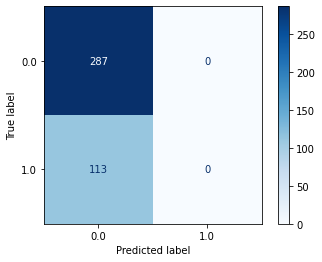

In [ ]:
#Acuracia, Revocação e Precisão respectivamento do modelo de treinamento svm

from sklearn import metrics

print("--------------SVM---------------")
print("Acuracia:" , clf.score(x_test, y_test))
print("Acuracia treino:")
y_pred_clf = model.predict(x_test)
plot_confusion_matrix(clf, x_test, y_test, cmap='Blues')
print("Revocação:",metrics.recall_score(y_pred_clf , y_test, average="binary"))
print("Precisão:",precision_score(y_pred_clf , y_test, average="binary"))

--------------KNN---------------
Acuracia: 0.7225
Acuracia treino:
Revocação: 0.5125
Precisão: 0.36283185840707965


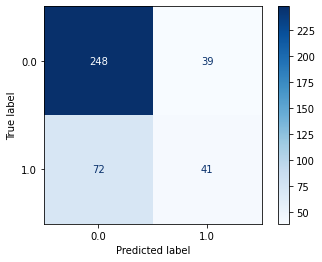

In [ ]:
#Acuracia, Revocação e Precisão respectivamento do modelo de treinamento KNN
print("--------------KNN---------------")
print("Acuracia:",knn_model.score(x_test, y_test))
print("Acuracia treino:")
y_pred_knn = knn_model.predict(x_test)
plot_confusion_matrix(knn_model, x_test, y_test, cmap='Blues')
print("Revocação:",recall_score(y_pred_knn , y_test, average="binary"))
print("Precisão:",precision_score(y_pred_knn , y_test, average="binary"))

--------------Arvore de decisão---------------
Acuracia: 0.855
Acuracia treino: 0.9783333333333334
Revocação: 0.7272727272727273
Precisão: 0.7787610619469026


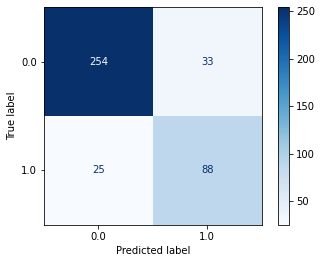

In [ ]:
#Acuracia, Revocação e Precisão respectivamento do modelo de treinamento Arvore de decisão
print("--------------Arvore de decisão---------------")
print("Acuracia:",model.score(x_test, y_test))
print("Acuracia treino:",model.score(x_train,y_train))
y_pred_tree = model.predict(x_test)
plot_confusion_matrix(model, x_test, y_test, cmap='Blues')
print("Revocação:",recall_score(y_pred_tree , y_test, average="binary"))
print("Precisão:",precision_score(y_pred_tree , y_test, average="binary"))

--------------Random Forest Model---------------
Acuracia: 0.8675
Acuracia treino: 0.9733333333333334
Revocação: 0.7678571428571429
Precisão: 0.7610619469026548


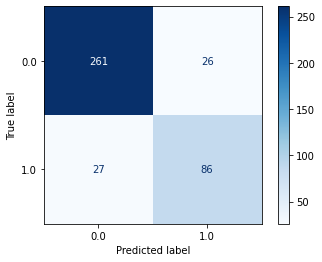

In [ ]:
#Acuracia, Revocação e Precisão respectivamento do modelo de treinamento Random Forest Model
print("--------------Random Forest Model---------------")
y_pred_rcf = rfcModel.predict(x_test)

plot_confusion_matrix(rfcModel, x_test, y_test, cmap='Blues')

print("Acuracia:",rfcModel.score(x_test, y_test))
print("Acuracia treino:", rfcModel.score(x_train,y_train))
print("Revocação:",recall_score(y_pred_rcf, y_test, average="binary"))
print("Precisão:",precision_score(y_pred_rcf, y_test, average="binary"))

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

<h1>Não rodar essa cedula</h1>

**Teste de hiperparâmetros**
- Fase 14: Nesta etapa, utilizamos os teste de hiperparâmetros para testar os modelos criados
- Desta forma, procuramos utilizar Grid Search e o Random Search para testar o nosso modelo preditivo. Resultando nos melhores parâmetros para ajudar o modelo a chegar no resultado desejado

**Hiperparâmetros:**
- hiperparâmetros selecionados para teste

In [ ]:
# Definir o espaço possível dos hiperparametros a serem testados no modelo
parametros = {'n_estimators':[80,90,100,110,120],
              'criterion':["gini", "entropy", "log_loss"],
              "class_weight":["balanced", "balanced_subsample"],
              "warm_start":[True, False],}
            

**Grid Search**

In [ ]:
grid_search = GridSearchCV(estimator = RandomForestClassifier() , param_grid=parametros)
grid_search.fit(x_train, y_train.squeeze())

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'class_weight': ['balanced', 'balanced_subsample'],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'n_estimators': [80, 90, 100, 110, 120],
                         'warm_start': [True, False]})

Resultados obtidos:

In [ ]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.86
{'class_weight': 'balanced_subsample', 'criterion': 'gini', 'n_estimators': 90, 'warm_start': False}


**Random Search**

In [ ]:
randomized_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions=parametros)
randomized_search.fit(x_train, y_train.squeeze())

RandomizedSearchCV(estimator=RandomForestClassifier(),
                   param_distributions={'class_weight': ['balanced',
                                                         'balanced_subsample'],
                                        'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'n_estimators': [80, 90, 100, 110, 120],
                                        'warm_start': [True, False]})

Resultados obtidos:

In [ ]:
print(randomized_search.best_score_)
print(randomized_search.best_params_)

0.86
{'warm_start': True, 'n_estimators': 110, 'criterion': 'entropy', 'class_weight': 'balanced_subsample'}


**Conclusão**
- Ao final, podemos concluir que o melhor hiperparâmetro para ser utilizado é o Grid Search. Pois além do best_score ter sido o melhor, ele permite fazer todos os teste possíveis, caso contrario do Random Search, já que ele faz teste aleatórios.
- Desta forma, nossos hiperparâmetros são: {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'n_estimators': 100, 'warm_start': False}